In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from typing import Dict, List
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize,normalize
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.ndimage import zoom
from functools import reduce
from scipy.io import loadmat
from skimage.measure import block_reduce
from collections import Counter
from scipy.sparse import coo_matrix,hstack, vstack
import cv2
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.ops as ops
torch.cuda.set_device(1)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


1


In [2]:
tstart = time.time()
root_dir = '/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/' #the path of images
trData = pd.read_csv(root_dir+"trainset.csv" , sep=',')
teData = pd.read_csv(root_dir+"testset.csv" , sep=',')
#trainset 
trN, trI, trM, trY = [],[],[],[]
for iname, itype in np.array(trData).tolist():
    try:
        trN.append(iname)
        trY.append(itype) #0 refer to Benign, and 1 refers to malignant
        image_path = os.path.join(root_dir, 'image', iname)
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        trI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname)
        mask = cv2.resize(cv2.imread(mask_path,0).astype(np.float32), (256, 256))/255#(256,256)
        trM.append(np.where(mask == 0.0, 0, 1)) #0, 1
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(trN),trData.shape[0]))
    sys.stdout.flush()
print('The length of trainset is %d'%len(trN))
#testset
teN, teI, teM, teY = [],[],[],[]
for iname, itype in np.array(teData).tolist():
    try:
        teN.append(iname)
        teY.append(itype) #0 refer to Benign, and 1 refers to malignant
        image_path = os.path.join(root_dir, 'image', iname)
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        teI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname)
        mask = cv2.resize(cv2.imread(mask_path,0).astype(np.float32), (256, 256))/255#(256,256)
        teM.append(np.where(mask == 0.0, 0, 1))
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(teN),teData.shape[0]))
    sys.stdout.flush()
print('The length of testset is %d'%len(teN))

elapsed = time.time() - tstart
print('Completed data handle in %d seconds' % int(elapsed))

3279 / 3279 The length of trainset is 3279
365 / 365 The length of testset is 365
Completed data handle in 114 seconds


In [37]:
class L2Normalization(nn.Module):
    def __init__(self):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(L2Normalization, self).__init__()
        self.eps = 1e-8
        
    def forward(self, x):
        if x.is_cuda:
            caped_eps = Variable(torch.Tensor([self.eps])).cuda(torch.cuda.device_of(x).idx)
        else:
            caped_eps = Variable(torch.Tensor([self.eps]))
        x = torch.div(x.transpose(0,1),x.max(1)[0]).transpose(0,1) # max_normed
        norm = torch.norm(x,2,1) + caped_eps.expand(x.size()[0])
        y = torch.div(x.transpose(0,1),norm).transpose(0,1)
        return y
    
class RMAC(nn.Module):
    """
    Regional Maximum activation of convolutions (R-MAC).
    c.f. https://arxiv.org/pdf/1511.05879.pdf
    Args:
        level_n (int): number of levels for selecting regions.
    """
    def __init__(self,level_n:int):
        super(RMAC, self).__init__()
        self.first_show = True
        self.cached_regions = dict()
        self.level_n = level_n

    def _get_regions(self, h: int, w: int) -> List:
        """
        Divide the image into several regions.
        Args:
            h (int): height for dividing regions.
            w (int): width for dividing regions.
        Returns:
            regions (List): a list of region positions.
        """
        if (h, w) in self.cached_regions:
            return self.cached_regions[(h, w)]

        m = 1
        n_h, n_w = 1, 1
        regions = list()
        if h != w:
            min_edge = min(h, w)
            left_space = max(h, w) - min(h, w)
            iou_target = 0.4
            iou_best = 1.0
            while True:
                iou_tmp = (min_edge ** 2 - min_edge * (left_space // m)) / (min_edge ** 2)

                # small m maybe result in non-overlap
                if iou_tmp <= 0:
                    m += 1
                    continue

                if abs(iou_tmp - iou_target) <= iou_best:
                    iou_best = abs(iou_tmp - iou_target)
                    m += 1
                else:
                    break
            if h < w:
                n_w = m
            else:
                n_h = m

        for i in range(self.level_n):
            region_width = int(2 * 1.0 / (i + 2) * min(h, w))
            step_size_h = (h - region_width) // n_h
            step_size_w = (w - region_width) // n_w

            for x in range(n_h):
                for y in range(n_w):
                    st_x = step_size_h * x
                    ed_x = st_x + region_width - 1
                    assert ed_x < h
                    st_y = step_size_w * y
                    ed_y = st_y + region_width - 1
                    assert ed_y < w
                    regions.append((st_x, st_y, ed_x, ed_y))

            n_h += 1
            n_w += 1

        self.cached_regions[(h, w)] = regions
        return regions

    def forward(self, fea:torch.tensor) -> torch.tensor:
        final_fea = None
        if fea.ndimension() == 4:
            h, w = fea.shape[2:]       
            regions = self._get_regions(h, w)
            for _, r in enumerate(regions):
                st_x, st_y, ed_x, ed_y = r
                region_fea = (fea[:, :, st_x: ed_x, st_y: ed_y].max(dim=3)[0]).max(dim=2)[0]#max-pooling
                region_fea = region_fea / torch.norm(region_fea, dim=1, keepdim=True)#PCA-whitening
                if final_fea is None:
                    final_fea = region_fea
                else:
                    final_fea = final_fea + region_fea
        else:# In case of fc feature.
            assert fea.ndimension() == 2
            if self.first_show:
                print("[RMAC Aggregator]: find 2-dimension feature map, skip aggregation")
                self.first_show = False
            final_fea = fea
        return final_fea
    
class CircleLoss(nn.Module):
    def __init__(self, scale=32, margin=0.25, similarity='cos', **kwargs):
        super(CircleLoss, self).__init__()
        self.scale = scale
        self.margin = margin
        self.similarity = similarity
        
    def forward(self, feats, labels):
        assert feats.size(0) == labels.size(0), \
            f"feats.size(0): {feats.size(0)} is not equal to labels.size(0): {labels.size(0)}"
        batch_size = feats.size(0)
        if self.similarity == 'dot':
            sim_mat = torch.matmul(feats, torch.t(feats))
        elif self.similarity == 'cos':
            feats = F.normalize(feats)
            sim_mat = feats.mm(feats.t())
        else:
            raise ValueError('This similarity is not implemented.')
        loss = list()
        for i in range(batch_size):
            pos_index = labels == labels[i]
            pos_index[i] = 0
            neg_index = labels != labels[i]
            pos_pair_ = sim_mat[i][pos_index]
            neg_pair_ = sim_mat[i][neg_index]

            alpha_p = torch.relu(-pos_pair_ + 1 + self.margin)
            alpha_n = torch.relu(neg_pair_ + self.margin)
            margin_p = 1 - self.margin
            margin_n = self.margin
            loss_p = torch.sum(torch.exp(-self.scale * alpha_p * (pos_pair_ - margin_p)))
            loss_n = torch.sum(torch.exp(self.scale * alpha_n * (neg_pair_ - margin_n)))
            loss.append(torch.log(1 + loss_p * loss_n))

        loss = sum(loss) / batch_size
        return loss
    
class YNetLoss(nn.Module):
    def __init__(self, lr=0.001):
        super(YNetLoss, self).__init__()
        self.alpha = nn.Parameter(torch.FloatTensor([0.01]))
        #self.beta = nn.Parameter(torch.FloatTensor([1.0]))
        #self.l1_reg = nn.Parameter(F.normalize(torch.tensor([torch.abs(self.alpha), torch.abs(self.beta)]), p=1, dim=0))
        self.lr = lr #weight_decay
        
    def forward(self,clloss, celoss): 
        #l2_reg = self.lr* (torch.norm(torch.abs(self.alpha), p=2) + torch.norm(torch.abs(1-self.alpha), p=2))
        #l2_reg = self.lr* (torch.norm(torch.abs(self.alpha), p=2)
        loss = torch.abs(self.alpha)*clloss + torch.abs(1-self.alpha)*celoss #+ l2_reg
        return loss
    
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class YNet(nn.Module):
    def __init__(self, block, num_blocks=[2,2,2,2], n_classes=2, code_size=64):
        super(YNet, self).__init__()
        # Bottom-up layers，classifcation loss
        self.in_planes = 8  #3 D->64 channels
        self.conv1 = nn.Conv2d(3, 8, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(8)

        self.layer2 = self._make_layer(block, 8, num_blocks[0], stride=1)
        self.layer3 = self._make_layer(block, 16, num_blocks[1], stride=2)
        self.layer4 = self._make_layer(block, 32, num_blocks[2], stride=2)
        self.layer5 = self._make_layer(block, 64, num_blocks[3], stride=2)
        self.conv6 = nn.Conv2d(256, 32, kernel_size=3, stride=2, padding=1)
        
        #self.fc1 = nn.Linear(32*4*4, code_size)#code_size:length of hash code
        self.fc1 = nn.Linear(256*8*8, code_size)
        self.fc2 = nn.Linear(code_size, n_classes) #num_classes:number of classes
        
        # Top-down layer, segmentation loss
        self.toplayer = nn.Conv2d(256, 32, kernel_size=1, stride=1, padding=0)  # Reduce channels
        
        self.latlayer1 = nn.Conv2d(128, 32, kernel_size=1, stride=1, padding=0)# Lateral layers
        self.latlayer2 = nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0)
        
        self.upsample = nn.Upsample((256,256), mode='bilinear',align_corners=True)
        self.conv7 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(3)#mask 0,1,2
        
        # Hash layer, ranking loss
        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.r_mac_pool = RMAC(level_n=3) 
        self.l2norm = L2Normalization()
        self.fc3 = nn.Linear(512, n_classes) #num_classes:number of classes

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _upsample_add(self, x, y):
        '''Upsample and add two feature maps.
        Args:
          x: (Variable) top feature map to be upsampled.
          y: (Variable) lateral feature map.
        Returns:
          (Variable) added feature map.
        Note in PyTorch, when input size is odd, the upsampled feature map
        with `F.upsample(..., scale_factor=2, mode='nearest')`
        maybe not equal to the lateral feature map size.
        e.g.
        original input size: [N,_,15,15] ->
        conv2d feature map size: [N,_,8,8] ->
        upsampled feature map size: [N,_,16,16]
        So we choose bilinear upsample which supports arbitrary output sizes.
        '''
        _,_,H,W = y.size()
        return F.upsample(x, size=(H,W), mode='bilinear') + y

    def forward(self, x):
        # Bottom-up, classifcation loss
        h1 = F.relu(self.bn1(self.conv1(x)))#(3,256,256)->(8,128,128)
        h1 = F.max_pool2d(h1, kernel_size=3, stride=2, padding=1)#(8,128,128)->(8,64,64)
        
        h2 = self.layer2(h1)#(8,64,64)->(32,64,64)
        h3 = self.layer3(h2)#(32,64,64)->(64,32,32)
        h4 = self.layer4(h3)#(64,32,32)->(128,16,16)
        h5 = self.layer5(h4)#(128,16,16)->(256,8,8)
        
        #h6 = self.conv6(h5)#(256,8,8)->(32,4,4) 
        h6 = h5.view(h5.size(0), -1)#conv->linear
        h_feat = self.fc1(h6)
        h_cls = self.fc2(h_feat)
        
        # Top-down, segmentation loss
        s5 = self.toplayer(h5)#(256,8,8)->(32,8,8)
        s4 = self._upsample_add(s5, self.latlayer1(h4))#{(32,8,8),(32, 16, 16)}->(32, 16, 16)
        s3 = self._upsample_add(s4, self.latlayer2(h3))#{(32, 16, 16),(32, 32, 32)}->(32, 32, 32)
        s2 = self._upsample_add(s3, h2) #{(32, 32, 32),(32, 64, 64)}->(32, 64, 64)
        
        s1 = self.upsample(s2)#(32, 64, 64)->(32, 256, 256)
        s_mask = self.bn2(self.conv7(s1))#(32, 256, 256)->(3, 256, 256)
        
        #Hash, ranking loss
        c5 = self.conv8(h5)#(256,8,8)->(512,8,8)
        
        c4 = self.r_mac_pool(c5) 
        
        c_feat = self.l2norm(c4) #512
        c_cls = self.fc3(c_feat)

        return h_feat, h_cls, s_mask, c_feat, c_cls

In [39]:
#define model
model = YNet(block=Bottleneck).cuda()#initialize model
ce_loss  = nn.CrossEntropyLoss().cuda() #for segmentation
cl_loss = CircleLoss().cuda() #for classification
ynet_loss = YNetLoss().cuda()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
optimizer = torch.optim.Adam([{'params':model.parameters()},{'params':ynet_loss.parameters()}], lr=0.001)
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trY)))
    on_trI = np.array(trI)[shuffled_idx]
    on_trM = np.array(trM)[shuffled_idx]
    on_trY = np.array(trY)[shuffled_idx]
    num_batches = len(trY) // batchSize + 1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        I_batch = torch.from_numpy(on_trI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(on_trY[min_idx:max_idx]).type(torch.LongTensor).cuda()
        m_batch = torch.from_numpy(on_trM[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        h_feat, h_cls, s_mask, c_feat, c_cls = model(I_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        #loss
        mask_loss = ce_loss(s_mask, m_batch)
        #mask_loss.backward(retain_graph=True)
        cls_loss =  cl_loss(c_feat, y_batch) #ce_loss(c_cls, y_batch)
        #cls_loss.backward()
        loss = ynet_loss(mask_loss, cls_loss)
        loss.backward()
        #update parameters
        optimizer.step()
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
model = model.cpu()#release gpu memory
torch.cuda.empty_cache()

#hash code of train data 
batchSize = 10
num_batches = len(trI) // batchSize +1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    x_hash, _, _, _, _ = best_net(x_batch.permute(0, 3, 1, 2))#forword
    trF.extend(x_hash.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data
teF = []
teM_pred = []
teY_pred = []
num_batches = len(teY) // batchSize  +1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, x_cls, x_mask, _, _ = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_mask = F.log_softmax(x_mask,dim=1) 
    m_pred = x_mask.max(1,keepdim=True)[1]
    teM_pred.extend(m_pred.cpu().data.numpy().tolist())
    x_cls = F.log_softmax(x_cls,dim=1) 
    y_pred = x_cls.max(1,keepdim=True)[1]
    teY_pred.extend(y_pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(64) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#retrieval performance
for topk in [5,10,20,50]:
    mAP = [] #mean average precision
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                pos_len = pos_len +1
                mAP.append(pos_len/rank_len) 
            else: 
                mAP.append(0)
    print("mAP@{}={:.4f}".format(topk, np.mean(mAP)))
#segementation performance  
mIoU=[]
for i in range(len(teM)):
    a = teM[i]
    b = np.array(teM_pred[i][0])
    #iou_score = np.where(abs(a.flatten()-b.flatten())<0.5,1,0)
    #iou_score = np.where(a.flatten()==b.flatten(),1,0)
    iou_score = a == b
    mIoU.append(np.mean(iou_score))
print("mIoU={:.4f}".format(np.mean(mIoU)))
#classification performance
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))

 2 / 328 : loss = 19.202026

/root/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/root/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


 328 / 328 : loss = 10.373492Eopch:     1 mean_loss = 14.566898
 328 / 328 : loss = 5.5584421Eopch:     2 mean_loss = 8.645347
 328 / 328 : loss = 1.042455Eopch:     3 mean_loss = 3.584096
 328 / 328 : loss = 0.226563Eopch:     4 mean_loss = 0.354351
 328 / 328 : loss = 0.240746Eopch:     5 mean_loss = 0.255726
 328 / 328 : loss = 0.194767Eopch:     6 mean_loss = 0.228353
 328 / 328 : loss = 0.188619Eopch:     7 mean_loss = 0.206118
 328 / 328 : loss = 0.194282Eopch:     8 mean_loss = 0.192212
 328 / 328 : loss = 0.159125Eopch:     9 mean_loss = 0.182042
 328 / 328 : loss = 0.118645Eopch:    10 mean_loss = 0.173875
best_loss = 0.173875
 36 / 37 8 Completed buliding index in 1 seconds
mAP@5=0.4159
mAP@10=0.3690
mAP@20=0.3359
mAP@50=0.3039
mIoU=0.9336
Accuracy: 0.460274


In [41]:
#define model
model = YNet(block=Bottleneck).cuda()#initialize model
ce_loss  = nn.CrossEntropyLoss().cuda() #for segmentation
cl_loss = CircleLoss().cuda() #for classification
ynet_loss = YNetLoss().cuda()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
optimizer = torch.optim.Adam([{'params':model.parameters()},{'params':ynet_loss.parameters()}], lr=0.001)
#train model
best_net, best_loss = None, float('inf')
couple_loss, sum_loss, cls_loss, seg_loss = [], [], [], []
batchSize = 10
for epoch in range(50):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trY)))
    on_trI = np.array(trI)[shuffled_idx]
    on_trM = np.array(trM)[shuffled_idx]
    on_trY = np.array(trY)[shuffled_idx]
    num_batches = len(trY) // batchSize + 1
    couple_loss_b, sum_loss_b, cls_loss_b, seg_loss_b = [], [], [], []
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        I_batch = torch.from_numpy(on_trI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(on_trY[min_idx:max_idx]).type(torch.LongTensor).cuda()
        m_batch = torch.from_numpy(on_trM[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        h_feat, h_cls, s_mask, c_feat, c_cls = model(I_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        #loss
        mask_loss = ce_loss(s_mask, m_batch)
        seg_loss_b.append(mask_loss.item())
        #mask_loss.backward(retain_graph=True)
        label_loss =  cl_loss(c_feat, y_batch) #ce_loss(c_cls, y_batch)
        cls_loss_b.append(label_loss.item())
        sum_loss_b.append(mask_loss.item()+label_loss.item())
        #cls_loss.backward()
        loss = ynet_loss(mask_loss, label_loss)
        couple_loss_b.append(loss.item())
        loss.backward()
        #update parameters
        optimizer.step()
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
    cls_loss.append(np.mean(cls_loss_b))
    seg_loss.append(np.mean(seg_loss_b))
    sum_loss.append(np.mean(sum_loss_b))
    couple_loss.append(np.mean(couple_loss_b))
print("best_loss = %.6f" % (best_loss))
model = model.cpu()#release gpu memory
torch.cuda.empty_cache()

#hash code of train data 
batchSize = 10
num_batches = len(trI) // batchSize +1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    x_hash, _, _, _, _ = best_net(x_batch.permute(0, 3, 1, 2))#forword
    trF.extend(x_hash.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data
teF = []
teM_pred = []
teY_pred = []
num_batches = len(teY) // batchSize  +1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, x_cls, x_mask, _, _ = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_mask = F.log_softmax(x_mask,dim=1) 
    m_pred = x_mask.max(1,keepdim=True)[1]
    teM_pred.extend(m_pred.cpu().data.numpy().tolist())
    x_cls = F.log_softmax(x_cls,dim=1) 
    y_pred = x_cls.max(1,keepdim=True)[1]
    teY_pred.extend(y_pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(64) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#retrieval performance
for topk in [5,10,20,50]:
    mAP = [] #mean average precision
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                pos_len = pos_len +1
                mAP.append(pos_len/rank_len) 
            else: 
                mAP.append(0)
    print("mAP@{}={:.4f}".format(topk, np.mean(mAP)))
#segementation performance  
mIoU=[]
for i in range(len(teM)):
    a = teM[i]
    b = np.array(teM_pred[i][0])
    #iou_score = np.where(abs(a.flatten()-b.flatten())<0.5,1,0)
    #iou_score = np.where(a.flatten()==b.flatten(),1,0)
    iou_score = a == b
    mIoU.append(np.mean(iou_score))
print("mIoU={:.4f}".format(np.mean(mIoU)))
#classification performance
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))

 328 / 328 : loss = 10.780162Eopch:     1 mean_loss = 14.555619
 328 / 328 : loss = 6.2202566Eopch:     2 mean_loss = 8.682255
 328 / 328 : loss = 1.142821Eopch:     3 mean_loss = 3.642728
 328 / 328 : loss = 0.219121Eopch:     4 mean_loss = 0.372026
 328 / 328 : loss = 0.212558Eopch:     5 mean_loss = 0.263602
 328 / 328 : loss = 0.214131Eopch:     6 mean_loss = 0.238583
 328 / 328 : loss = 0.250647Eopch:     7 mean_loss = 0.217537
 328 / 328 : loss = 0.197438Eopch:     8 mean_loss = 0.203566
 328 / 328 : loss = 0.136543Eopch:     9 mean_loss = 0.191742
 328 / 328 : loss = 0.150651Eopch:    10 mean_loss = 0.183663
 328 / 328 : loss = 0.158842Eopch:    11 mean_loss = 0.175268
 328 / 328 : loss = 0.145121Eopch:    12 mean_loss = 0.170770
 328 / 328 : loss = 0.121755Eopch:    13 mean_loss = 0.165935
 328 / 328 : loss = 0.171534Eopch:    14 mean_loss = 0.160215
 328 / 328 : loss = 0.178547Eopch:    15 mean_loss = 0.156696
 328 / 328 : loss = 0.131424Eopch:    16 mean_loss = 0.153227
 328 

In [ ]:
cls_loss_f = [22.45456524218543, 18.288264581712625, 17.526648650735112, 16.369235071085267, 15.680953979492188, 15.838115659810729, 14.81462464090121, 15.548834736064329, 15.17564285407632, 15.231133751950022, 15.527478702997756, 14.792398388102903, 15.234505022986461, 14.791661278676179, 14.862128839654437, 14.651630062167927, 14.142049854084597, 14.636550580040883, 14.02748534639003, 14.257431337388896, 14.378984111850544, 13.70201070429915, 14.556365384893903, 14.176501710536117, 13.731929326461533, 13.959695169481181, 13.545124538874221, 14.185181375277244, 14.794458453938113, 14.571867975138002, 13.602665529412738, 13.999899023670261, 13.813231015609482, 14.445749735428116, 14.224827055203713, 14.684520495139946, 13.58569457167286, 13.964108159986592, 13.65930384296482, 14.436943749249991, 14.318670192007291, 14.55568648192842, 14.130320856126689, 14.822026753829697, 14.010519771252648, 14.651774584236792, 13.900295403044103, 14.448740037821107, 14.526879245952024, 14.51106326862917]
seg_loss_f = [1.0663021257368184, 0.9503612841589976, 0.8460714806944637, 0.7511755025992959, 0.6647668652615305, 0.5865597795631926, 0.5196492247662302, 0.4613876974178573, 0.41017452842098173, 0.3641700936576067, 0.3270916716527131, 0.2920098718950304, 0.26217549710960714, 0.23335772449687375, 0.21184392096632618, 0.18975625654398384, 0.1713846373861119, 0.1562514075283277, 0.14272182245375747, 0.1309481381864871, 0.12097001542984429, 0.1123603511664827, 0.10498694999743316, 0.09819582243592052, 0.09255327044402138, 0.08732781736022335, 0.08260900539866949, 0.07834657205868575, 0.07459863300545741, 0.07110816783319085, 0.06795840255789838, 0.0650154849735357, 0.06221856795630212, 0.05991757130723888, 0.05735508756617368, 0.055130892385870725, 0.053461196437730625, 0.05123176166819314, 0.049621206660897046, 0.047893579228449674, 0.04628239793039984, 0.04469348685973781, 0.04341755005515228, 0.04199559658260669, 0.04071477295483573, 0.039656542115292306, 0.03881673849487709, 0.03770621884929932, 0.03637067632654966, 0.035345101697465124]
sum_loss_f = [23.52086736792225, 19.238625865871622, 18.372720131429574, 17.120410573684563, 16.345720844753718, 16.42467543937392, 15.33427386566744, 16.010222433482188, 15.585817382497302, 15.595303845607628, 15.85457037465047, 15.084408259997934, 15.496680520096067, 15.025019003173052, 15.073972760620764, 14.841386318711912, 14.313434491470709, 14.792801987569211, 14.170207168843787, 14.388379475575382, 14.49995412728039, 13.814371055465633, 14.661352334891335, 14.274697532972036, 13.824482596905554, 14.047022986841403, 13.62773354427289, 14.26352794733593, 14.86905708694357, 14.642976142971193, 13.670623931970637, 14.064914508643797, 13.875449583565784, 14.505667306735354, 14.282182142769885, 14.739651387525818, 13.63915576811059, 14.015339921654785, 13.708925049625716, 14.484837328478442, 14.36495258993769, 14.60037996878816, 14.17373840618184, 14.864022350412304, 14.051234544207484, 14.691431126352084, 13.93911214153898, 14.486446256670407, 14.563249922278574, 14.546408370326636]
couple_loss_f = [21.682999927297992, 16.737896655449422, 15.1908966979738, 13.391131098240109, 12.07219904358104, 11.407120096481453, 9.939303473143255, 9.636746762920234, 8.613822262923597, 7.841101626976061, 7.153462843117067, 6.021548044378474, 5.372691410577904, 4.416240615107245, 3.625308961181317, 2.778873702227059, 1.9292534971136157, 1.2036534418999139, 0.4114252033375077, 0.13810823226379135, 0.1222600468387038, 0.11344211826385078, 0.10650655589366363, 0.09974170829785073, 0.09530373965784655, 0.08941562600054984, 0.08457606576256833, 0.08120491658732043, 0.07619576762288303, 0.07256394877272138, 0.0698865542219857, 0.06803886497677383, 0.06360979157231622, 0.0615219477627237, 0.05915247933086702, 0.05651354082560135, 0.05456652170268156, 0.0546632464028011, 0.05156598574781822, 0.05010486375224792, 0.04793167158456172, 0.04709497144666769, 0.04471903673167956, 0.0442596430874477, 0.04451406683962224, 0.04212263794773716, 0.04023681953549385, 0.040079236220000154, 0.03801465268104763, 0.03809762828178325]

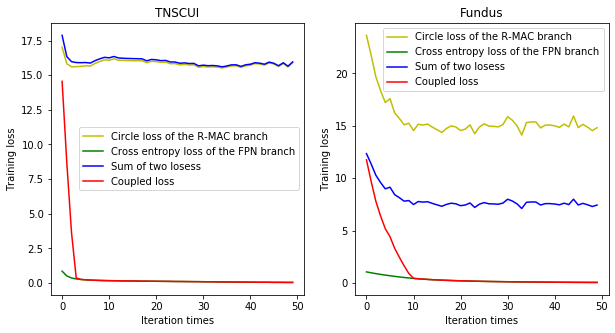

In [42]:
import numpy as np
import matplotlib.pyplot as plt

x_axix = range(50)
#sub_axix = filter(lambda x:x%50 == 0, x_axix)
plt.figure(figsize=(10,5))

# 1
plt.subplot(1, 2, 1)
cls_loss_pt = plt.plot(x_axix,cls_loss,label='Circle loss of the R-MAC branch', color='y')
seg_loss_pt = plt.plot(x_axix,seg_loss,label='Cross entropy loss of the FPN branch', color='g')
sum_loss_pt = plt.plot(x_axix,sum_loss,label='Sum of two losess', color='b', linestyle='-')
couple_loss_pt = plt.plot(x_axix,couple_loss,label='Coupled loss', color='r', linestyle='-')
plt.xlabel('Iteration times')
plt.ylabel('Training loss')
plt.title('TNSCUI')
plt.legend()
# 2
plt.subplot(1, 2, 2)
cls_loss_pt = plt.plot(x_axix,cls_loss_f,label='Circle loss of the R-MAC branch', color='y')
seg_loss_pt = plt.plot(x_axix,seg_loss_f,label='Cross entropy loss of the FPN branch', color='g')
sum_loss_pt = plt.plot(x_axix,sum_loss_f,label='Sum of two losess', color='b', linestyle='-')
couple_loss_pt = plt.plot(x_axix,couple_loss_f,label='Coupled loss', color='r', linestyle='-')
plt.xlabel('Iteration times')
plt.ylabel('Training loss')
plt.title('Fundus')
plt.legend()

In [3]:
class L2Normalization(nn.Module):
    def __init__(self):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(L2Normalization, self).__init__()
        self.eps = 1e-8
        
    def forward(self, x):
        if x.is_cuda:
            caped_eps = Variable(torch.Tensor([self.eps])).cuda(torch.cuda.device_of(x).idx)
        else:
            caped_eps = Variable(torch.Tensor([self.eps]))
        x = torch.div(x.transpose(0,1),x.max(1)[0]).transpose(0,1) # max_normed
        norm = torch.norm(x,2,1) + caped_eps.expand(x.size()[0])
        y = torch.div(x.transpose(0,1),norm).transpose(0,1)
        return y
    
class RMAC(nn.Module):
    """
    Regional Maximum activation of convolutions (R-MAC).
    c.f. https://arxiv.org/pdf/1511.05879.pdf
    Args:
        level_n (int): number of levels for selecting regions.
    """
    def __init__(self,level_n:int):
        super(RMAC, self).__init__()
        self.first_show = True
        self.cached_regions = dict()
        self.level_n = level_n

    def _get_regions(self, h: int, w: int) -> List:
        """
        Divide the image into several regions.
        Args:
            h (int): height for dividing regions.
            w (int): width for dividing regions.
        Returns:
            regions (List): a list of region positions.
        """
        if (h, w) in self.cached_regions:
            return self.cached_regions[(h, w)]

        m = 1
        n_h, n_w = 1, 1
        regions = list()
        if h != w:
            min_edge = min(h, w)
            left_space = max(h, w) - min(h, w)
            iou_target = 0.4
            iou_best = 1.0
            while True:
                iou_tmp = (min_edge ** 2 - min_edge * (left_space // m)) / (min_edge ** 2)

                # small m maybe result in non-overlap
                if iou_tmp <= 0:
                    m += 1
                    continue

                if abs(iou_tmp - iou_target) <= iou_best:
                    iou_best = abs(iou_tmp - iou_target)
                    m += 1
                else:
                    break
            if h < w:
                n_w = m
            else:
                n_h = m

        for i in range(self.level_n):
            region_width = int(2 * 1.0 / (i + 2) * min(h, w))
            step_size_h = (h - region_width) // n_h
            step_size_w = (w - region_width) // n_w

            for x in range(n_h):
                for y in range(n_w):
                    st_x = step_size_h * x
                    ed_x = st_x + region_width - 1
                    assert ed_x < h
                    st_y = step_size_w * y
                    ed_y = st_y + region_width - 1
                    assert ed_y < w
                    regions.append((st_x, st_y, ed_x, ed_y))

            n_h += 1
            n_w += 1

        self.cached_regions[(h, w)] = regions
        return regions

    def forward(self, fea:torch.tensor) -> torch.tensor:
        final_fea = None
        if fea.ndimension() == 4:
            h, w = fea.shape[2:]       
            regions = self._get_regions(h, w)
            for _, r in enumerate(regions):
                st_x, st_y, ed_x, ed_y = r
                region_fea = (fea[:, :, st_x: ed_x, st_y: ed_y].max(dim=3)[0]).max(dim=2)[0]#max-pooling
                region_fea = region_fea / torch.norm(region_fea, dim=1, keepdim=True)#PCA-whitening
                if final_fea is None:
                    final_fea = region_fea
                else:
                    final_fea = final_fea + region_fea
        else:# In case of fc feature.
            assert fea.ndimension() == 2
            if self.first_show:
                print("[RMAC Aggregator]: find 2-dimension feature map, skip aggregation")
                self.first_show = False
            final_fea = fea
        return final_fea

In [4]:
#https://github.com/luyajie/triplet-deep-hash-pytorch#triplet-deep-hash-pytorch            
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self,H_q,H_p,H_n):    
        margin_val = self.margin * H_q.shape[1]
        squared_loss_pos = torch.mean(self.mse_loss(H_q, H_p), dim=1)
        squared_loss_neg = torch.mean(self.mse_loss(H_q, H_n), dim=1)
        zeros = torch.zeros_like(squared_loss_neg)
        loss  = torch.max(zeros, margin_val - squared_loss_neg + squared_loss_pos)
        return torch.mean(loss)
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class NNet(nn.Module):
    def __init__(self, block, num_blocks=[2,2,2,2], n_classes=2, code_size=64):
        super(NNet, self).__init__()
        # Bottom-up layers，classifcation loss
        self.in_planes = 8  #3 D->64 channels
        self.conv1 = nn.Conv2d(3, 8, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(8)

        self.layer2 = self._make_layer(block, 8, num_blocks[0], stride=1)
        self.layer3 = self._make_layer(block, 16, num_blocks[1], stride=2)
        self.layer4 = self._make_layer(block, 32, num_blocks[2], stride=2)
        self.layer5 = self._make_layer(block, 64, num_blocks[3], stride=2)
        self.conv6 = nn.Conv2d(256, 32, kernel_size=3, stride=2, padding=1)
        
        self.fc1 = nn.Linear(32*4*4, code_size)#code_size:length of hash code
        self.fc2 = nn.Linear(code_size, n_classes) #num_classes:number of classes
        
        # Top-down layer, segmentation loss
        self.toplayer = nn.Conv2d(256, 32, kernel_size=1, stride=1, padding=0)  # Reduce channels
        
        self.latlayer1 = nn.Conv2d(128, 32, kernel_size=1, stride=1, padding=0)# Lateral layers
        self.latlayer2 = nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0)
        
        self.upsample = nn.Upsample((256,256), mode='bilinear',align_corners=True)
        self.conv7 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(2)#mask 0,1,2
        
        # Hash layer, ranking loss
        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.r_mac_pool = RMAC(level_n=3) 
        self.l2norm = L2Normalization()
        self.fc3 = nn.Linear(512, n_classes) #num_classes:number of classes

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _upsample_add(self, x, y):
        '''Upsample and add two feature maps.
        Args:
          x: (Variable) top feature map to be upsampled.
          y: (Variable) lateral feature map.
        Returns:
          (Variable) added feature map.
        Note in PyTorch, when input size is odd, the upsampled feature map
        with `F.upsample(..., scale_factor=2, mode='nearest')`
        maybe not equal to the lateral feature map size.
        e.g.
        original input size: [N,_,15,15] ->
        conv2d feature map size: [N,_,8,8] ->
        upsampled feature map size: [N,_,16,16]
        So we choose bilinear upsample which supports arbitrary output sizes.
        '''
        _,_,H,W = y.size()
        return F.upsample(x, size=(H,W), mode='bilinear') + y

    def forward(self, x):
        # Bottom-up, classifcation loss
        h1 = F.relu(self.bn1(self.conv1(x)))#(3,256,256)->(8,128,128)
        h1 = F.max_pool2d(h1, kernel_size=3, stride=2, padding=1)#(8,128,128)->(8,64,64)
        
        h2 = self.layer2(h1)#(8,64,64)->(32,64,64)
        h3 = self.layer3(h2)#(32,64,64)->(64,32,32)
        h4 = self.layer4(h3)#(64,32,32)->(128,16,16)
        h5 = self.layer5(h4)#(128,16,16)->(256,8,8)
        
        h6 = self.conv6(h5)#(256,8,8)->(32,4,4) 
        h6 = h6.view(h6.size(0), -1)#conv->linear
        h_feat = self.fc1(h6)
        h_cls = self.fc2(h_feat)
        
        # Top-down, segmentation loss
        s5 = self.toplayer(h5)#(256,8,8)->(32,8,8)
        s4 = self._upsample_add(s5, self.latlayer1(h4))#{(32,8,8),(32, 16, 16)}->(32, 16, 16)
        s3 = self._upsample_add(s4, self.latlayer2(h3))#{(32, 16, 16),(32, 32, 32)}->(32, 32, 32)
        s2 = self._upsample_add(s3, h2) #{(32, 32, 32),(32, 64, 64)}->(32, 64, 64)
        
        s1 = self.upsample(s2)#(32, 64, 64)->(32, 256, 256)
        s_mask = self.bn2(self.conv7(s1))#(32, 256, 256)->(2, 256, 256)
        
        #Hash, ranking loss
        c5 = self.conv8(h5)#(256,8,8)->(512,8,8)
        
        c4 = self.r_mac_pool(c5) 
        
        c_feat = self.l2norm(c4) #512
        c_cls = self.fc3(c_feat)

        return h_feat, h_cls, s_mask, c_feat, c_cls

In [5]:
net = NNet(block=Bottleneck)
fms = net(Variable(torch.randn(10,3,256,256)))
for fm in fms:
    print(fm.size())

/root/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/root/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([10, 64])
torch.Size([10, 2])
torch.Size([10, 2, 256, 256])
torch.Size([10, 512])
torch.Size([10, 2])


In [70]:
#Generate image pairs for model
def onlineGenImgPairs( ):
    idx_sf = []
    idx_0 = np.where( np.array(trY) == 0 ) #class 0
    idx_0 = list(idx_0[0])
    idx_sf.extend(idx_0)
    idx_1 = np.where( np.array(trY) == 1 ) #class 1
    idx_1 = list(idx_1[0])
    idx_sf.extend(idx_1)
    random.shuffle(idx_sf)   
    trQ_sf, trP_sf, trN_sf = [], [], []
    trQ_y, trP_y, trN_y = [], [], []
    trQ_m, trP_m, trN_m = [], [], []
    for iQ in idx_sf:
        trQ_sf.append(trI[iQ])
        trQ_y.append(trY[iQ])
        trQ_m.append(trM[iQ])
        if trY[iQ] == 0:
            idx_tmp = idx_0.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            trP_m.append(trM[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_0))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
            trN_m.append(trM[iN[0]])
        elif trY[iQ] == 1:
            idx_tmp = idx_1.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            trP_m.append(trM[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_1))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
            trN_m.append(trM[iN[0]])
        else: pass
        sys.stdout.write('\r{} / {} '.format(len(trQ_sf),len(idx_sf)))
        sys.stdout.flush()
    return np.array(trQ_sf),np.array(trP_sf),np.array(trN_sf), np.array(trQ_y), np.array(trP_y), np.array(trN_y), np.array(trQ_m), np.array(trP_m), np.array(trN_m)
#sample  triplet labels
#trQ_sf, trP_sf, trN_sf, trQ_y, trP_y, trN_y, trQ_m, trP_m, trN_m = onlineGenImgPairs() 
assert (trQ_sf.shape==trP_sf.shape and trQ_sf.shape==trN_sf.shape)
assert (trQ_y.shape==trP_y.shape and trQ_y.shape==trN_y.shape)
assert (trQ_m.shape==trP_m.shape and trQ_m.shape==trN_m.shape)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trP_y))!=0,1,0))==0.0)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trN_y))!=0,1,0))==1.0)

#define model
model = NNet(block=Bottleneck).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#tl_loss  = TripletLoss(margin=0.5).cuda() #define TripletLoss 
ce_loss  = nn.CrossEntropyLoss().cuda() #define ce mutli-classes #F.log_softmax+F.nll_loss
#mse_loss  = nn.MSELoss().cuda() #define mseloss
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_q_y = trQ_y[shuffled_idx]
    train_q_m = trQ_m[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_p_y = trP_y[shuffled_idx]
    train_p_m = trP_m[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    train_n_y = trN_y[shuffled_idx]
    train_n_m = trN_m[shuffled_idx]
    num_batches = len(trQ_sf) // batchSize + 1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Q_y_batch = torch.from_numpy(train_q_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        Q_m_batch = torch.from_numpy(train_q_m[min_idx:max_idx]).type(torch.LongTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_y_batch = torch.from_numpy(train_p_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        P_m_batch = torch.from_numpy(train_p_m[min_idx:max_idx]).type(torch.LongTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_y_batch = torch.from_numpy(train_n_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        N_m_batch = torch.from_numpy(train_n_m[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        Q_h_feat, Q_h_cls, Q_s_mask, Q_c_feat, Q_c_cls = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_h_feat, P_h_cls, P_s_mask, P_c_feat, P_c_cls = model(P_batch.permute(0, 3, 1, 2))
        N_h_feat, N_h_cls, N_s_mask, N_c_feat, N_c_cls = model(N_batch.permute(0, 3, 1, 2))
        #loss
        #rank_loss = tl_loss(Q_h_feat, P_h_feat, N_h_feat)
        #rank_loss.backward(retain_graph=True)
        mask_loss = ce_loss(Q_s_mask,Q_m_batch) + ce_loss(P_s_mask,P_m_batch) + ce_loss(N_s_mask,N_m_batch)
        mask_loss.backward(retain_graph=True)#buffer  #
        #cls_loss = ce_loss(Q_c_cls,Q_y_batch) + ce_loss(P_c_cls,P_y_batch) + ce_loss(N_c_cls,N_y_batch) 
        cls_loss = ce_loss(Q_h_cls,Q_y_batch) + ce_loss(P_h_cls,P_y_batch) + ce_loss(N_h_cls,N_y_batch) 
        cls_loss.backward() 
        optimizer.step()#update parameters
        #show loss
        loss = mask_loss + cls_loss 
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#model = model.cpu()#release gpu memory
#torch.cuda.empty_cache()

#hash code of train data 
batchSize = 10
num_batches = len(trI) // batchSize +1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    x_hash, _, _, _, _ = best_net(x_batch.permute(0, 3, 1, 2))#forword
    trF.extend(x_hash.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data
teF = []
teM_pred = []
teY_pred = []
num_batches = len(teY) // batchSize  +1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, x_cls, x_mask, _, _ = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_mask = F.log_softmax(x_mask,dim=1) 
    m_pred = x_mask.max(1,keepdim=True)[1]
    teM_pred.extend(m_pred.cpu().data.numpy().tolist())
    x_cls = F.log_softmax(x_cls,dim=1) 
    y_pred = x_cls.max(1,keepdim=True)[1]
    teY_pred.extend(y_pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(64) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#retrieval performance
for topk in [5,10,20,50]:
    mAP = [] #mean average precision
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                pos_len = pos_len +1
                mAP.append(pos_len/rank_len) 
            else: 
                mAP.append(0)
    print("mAP@{}={:.4f}".format(topk, np.mean(mAP)))
#segementation performance  
mIoU=[]
for i in range(len(teM)):
    a = teM[i]
    b = np.array(teM_pred[i][0])
    #iou_score = np.where(abs(a.flatten()-b.flatten())<0.5,1,0)
    #iou_score = np.where(a.flatten()==b.flatten(),1,0)
    iou_score = a == b
    mIoU.append(np.mean(iou_score))
print("mIoU={:.4f}".format(np.mean(mIoU)))
#classification performance
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))

 328 / 328 : loss = 2.921428Eopch:     1 mean_loss = 3.383659
 328 / 328 : loss = 2.583315Eopch:     2 mean_loss = 2.349023
 328 / 328 : loss = 1.812523Eopch:     3 mean_loss = 1.643134
 328 / 328 : loss = 1.203704Eopch:     4 mean_loss = 1.195198
 328 / 328 : loss = 1.068814Eopch:     5 mean_loss = 0.979761
 328 / 328 : loss = 0.625792Eopch:     6 mean_loss = 0.831462
 328 / 328 : loss = 0.724689Eopch:     7 mean_loss = 0.737056
 328 / 328 : loss = 0.630111Eopch:     8 mean_loss = 0.702051
 328 / 328 : loss = 0.717964Eopch:     9 mean_loss = 0.667016
 328 / 328 : loss = 1.016864Eopch:    10 mean_loss = 0.616458
best_loss = 0.616458
 36 / 37 8 Completed buliding index in 1 seconds
mAP@5=0.6165
mAP@10=0.6085
mAP@20=0.6026
mAP@50=0.5981
mIoU=0.9352
Accuracy: 0.660274


In [12]:
#release gpu memory
model = model.cpu()
ce_loss = ce_loss.cpu()
Q_batch = Q_batch.cpu()
Q_y_batch = Q_y_batch.cpu()
P_batch = P_batch.cpu()
P_y_batch = P_y_batch.cpu()
N_batch = N_batch.cpu()
N_y_batch = N_y_batch.cpu()
torch.cuda.empty_cache()

In [72]:
image_path_top = []
for i in [12]:#range(len(trY)):
    itype = trY[i]
    teVal = trF[i]
    image_path = os.path.join(root_dir, 'images', trN[i])
    map_item_score = {}
    scores, neighbors = gpu_index.search(np.array(trF[i:i+1]).astype('float32'), k=6)
    for j in neighbors[0].tolist():
        print ('pos: %d-itype:%d-dtype:%d'%(i,trY[i],trY[j]))
        image_path_top.append(trN[j])
print(image_path_top)

pos: 12-itype:1-dtype:1
pos: 12-itype:1-dtype:0
pos: 12-itype:1-dtype:1
pos: 12-itype:1-dtype:1
pos: 12-itype:1-dtype:1
pos: 12-itype:1-dtype:0
['4385.PNG', '82.PNG', '2796.PNG', '7553.PNG', '9362.PNG', '1522.PNG']


Counter({0: 59944, 1: 5592})


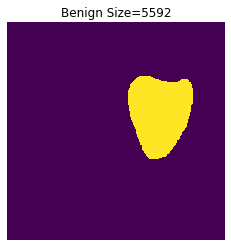

In [86]:
mask_path= '/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/mask/1522.PNG'
mask = cv2.resize(cv2.imread(mask_path,0).astype(np.float32), (256, 256))/255
mask = np.where(mask == 0.0, 0, 1)
print(Counter(mask.flatten()))
plt.title('Benign Size=5592' )#refer to Benign, and 1 refers to Malignant
plt.axis('off')
plt.imshow(mask)

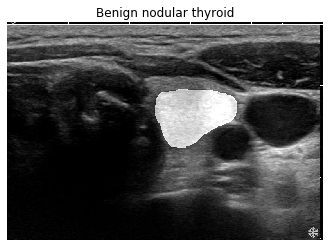

In [49]:
background = cv2.imread('/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/image/6818.PNG')
overlay = cv2.imread('/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/mask/6818.PNG')
#print(trY[0])
# Help please
added_image = cv2.addWeighted(background,1.0,overlay,0.6,0)
#added_image = cv2.bitwise_and(background, overlay)
#cv2.imwrite('combined.png', added_image)
#cv2.imshow("Image", added_image)
plt.axis('off')
plt.title('Benign nodular thyroid' )
plt.imshow(added_image)
plt.show()

torch.Size([512, 8, 8])


(-0.5, 255.5, 255.5, -0.5)

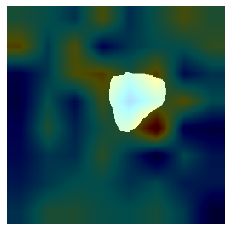

In [66]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# normalizing the output
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img
#input image
#image_path='/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/image/'+teN[0]
image_path ='/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/mask/'+teN[0]
oriImg = cv2.resize(cv2.imread(image_path), (256, 256))
#oriImg = cv2.applyColorMap(oriImg, cv2.COLORMAP_JET)

#train
data = torch.from_numpy(np.array(teI[0:1])).type(torch.FloatTensor).cuda()
output = best_net(data.permute(0, 3, 1, 2))#forword
#conv1         
best_net.conv8.register_forward_hook(get_activation('conv8'))#maxpool
feature = activation['conv8'].squeeze()
print(feature.shape)
feature = torch.mean(feature, dim=0).cpu().numpy()
feature = normalize_output(feature)
feature = np.uint8(255 * feature)
#plot
height, width = oriImg.shape[0],oriImg.shape[1]
featuremap = cv2.applyColorMap(cv2.resize(feature,(width, height)), cv2.COLORMAP_JET)
overlay_img = cv2.addWeighted(oriImg,0.7,featuremap,0.3,0)
plt.imshow(overlay_img)
plt.axis('off')

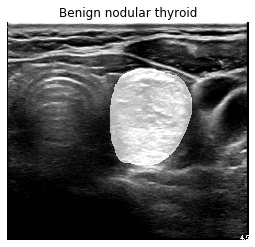

In [50]:
background = cv2.imread('/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/image/777.PNG')
overlay = cv2.imread('/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/mask/777.PNG')
#print(trY[0])
# Help please
added_image = cv2.addWeighted(background,1.0,overlay,0.6,0)
#added_image = cv2.bitwise_and(background, overlay)
#cv2.imwrite('combined.png', added_image)
#cv2.imshow("Image", added_image)
plt.axis('off')
plt.title('Benign nodular thyroid' )
plt.imshow(added_image)
plt.show()

torch.Size([512, 8, 8])


(-0.5, 255.5, 255.5, -0.5)

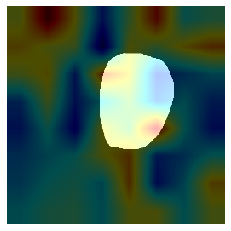

In [69]:
#input image
#image_path='/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/image/'+teN[9]
image_path ='/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/mask/'+teN[9]
oriImg = cv2.resize(cv2.imread(image_path), (256, 256))
#oriImg = cv2.applyColorMap(oriImg, cv2.COLORMAP_JET)

#train
data = torch.from_numpy(np.array(teI[9:10])).type(torch.FloatTensor).cuda()
output = best_net(data.permute(0, 3, 1, 2))#forword
#conv1         
best_net.conv8.register_forward_hook(get_activation('conv8'))#maxpool
feature = activation['conv8'].squeeze()
print(feature.shape)
feature = torch.mean(feature, dim=0).cpu().numpy()
feature = normalize_output(feature)
feature = np.uint8(255 * feature)
#plot
height, width = oriImg.shape[0],oriImg.shape[1]
featuremap = cv2.applyColorMap(cv2.resize(feature,(width, height)), cv2.COLORMAP_JET)
overlay_img = cv2.addWeighted(oriImg,0.7,featuremap,0.3,0)
plt.imshow(overlay_img)
plt.axis('off')

(-0.5, 919.5, 641.5, -0.5)

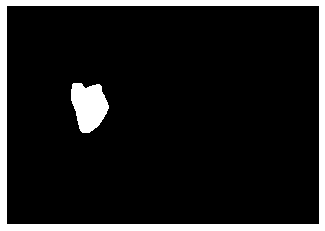

In [46]:
image_path ='/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/mask/'+trN[0]
mask = cv2.imread(image_path)
plt.imshow(mask)
plt.axis('off')

(256, 256)
Counter({0: 64192, 1: 1344})


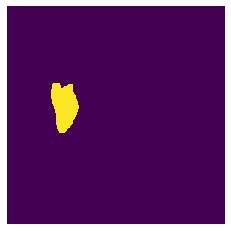

In [18]:
mask = trM[0]
print (mask.shape)
print(Counter(mask.flatten()))
imgplot = plt.imshow(mask)
plt.axis('off')
plt.show()

In [91]:
tstart = time.time()
num_batches = len(trI) // batchSize +1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    x_hash, _, _, _, _ = best_net(x_batch.permute(0, 3, 1, 2))#forword
    trF.extend(x_hash.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))

#hash code of test data
teF = []
teM_pred = []
teY_pred = []
num_batches = len(teY) // batchSize  +1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, x_cls, x_mask, _, _ = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_mask = F.log_softmax(x_mask,dim=1) 
    m_pred = x_mask.max(1,keepdim=True)[1]
    teM_pred.extend(m_pred.cpu().data.numpy().tolist())
    x_cls = F.log_softmax(x_cls,dim=1) 
    y_pred = x_cls.max(1,keepdim=True)[1]
    teY_pred.extend(y_pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(64) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#retrieval performance

tstart = time.time()
for topk in [5,10,20,50]:
    mAP = [] #mean average precision
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                pos_len = pos_len +1
                mAP.append(pos_len/rank_len) 
            else: 
                mAP.append(0)
    print("mAP@{}={:.4f}".format(topk, np.mean(mAP)))
elapsed = time.time() - tstart    
print('Completed buliding index in %f seconds' % elapsed)
#segementation performance  
mIoU=[]
for i in range(len(teM)):
    a = teM[i]
    b = np.array(teM_pred[i][0])
    #iou_score = np.where(abs(a.flatten()-b.flatten())<0.5,1,0)
    #iou_score = np.where(a.flatten()==b.flatten(),1,0)
    iou_score = a == b
    mIoU.append(np.mean(iou_score))
print("mIoU={:.4f}".format(np.mean(mIoU)))
#classification performance
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))


 327 / 328 Completed buliding index in 4 seconds
 36 / 37 Completed buliding index in 1 seconds
mAP@5=0.6165
mAP@10=0.6085
mAP@20=0.6026
mAP@50=0.5981
Completed buliding index in 0.033910 seconds
mIoU=0.9352
Accuracy: 0.660274
